## This is an algorithm that create and train a LSTM model that predict the max, min and mean for the future period of time of S&P index

### Loading packages

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Concatenate
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time
%matplotlib inline

Using TensorFlow backend.


### Function that is used to normalize the data to a fixed mean and std of data

In [22]:
def moving_normalize(df, mean_window_size=520, future_window_size=40):
    """
    Due to the fact that index is constantly growing, using a universal normalizing method is infeasible.
    The function use mean_window_size to calculate mean, and use the mean to divide future_window_size data.
    """
    out = df.copy()
    
    for i in range(mean_window_size, len(df)-future_window_size, future_window_size):
        out.iloc[i:i+future_window_size, :] = df.iloc[i:i+future_window_size, :] / df.iloc[i-mean_window_size:i, :].mean()
    
    i = i-future_window_size
    if not i == len(df)-future_window_size-1:
        out.iloc[i:, :] = df.iloc[i:, :] / df.iloc[i-mean_window_size:i, :].mean()
    
    return out.iloc[mean_window_size:, :] - 1

### Function that generate train data for the training and testing of the neural network

In [23]:
def generate_train_data(df, test_split=0.2, valid_split=0.1, input_len=20, output_len=10):
    """
    input is a sequence of length input_len
    output is a single value mean of length output_len
    """
    out = {}
    
    data_len = len(df)-output_len
    test_split_len = int(data_len*(1-test_split-valid_split))
    valid_split_len = int(data_len*(1-valid_split))
    
    out["train_input"] = np.array([df.iloc[i-input_len:i, :].values for i in range(input_len, test_split_len)])
    out["train_output_max"] = np.array([df.iloc[i:i+output_len, 1].max() for i in range(input_len, test_split_len)])
    out["train_output_min"] = np.array([df.iloc[i:i+output_len, 2].min() for i in range(input_len, test_split_len)])
    out["train_output_mean"] = np.array([df.iloc[i:i+output_len, [0, 3]].mean(axis=1).mean() for i in range(input_len, test_split_len)])
    out["test_input"] = np.array([df.iloc[i-input_len:i, :].values for i in range(test_split_len, valid_split_len)])
    out["test_output_max"] = np.array([df.iloc[i:i+output_len, 1].max() for i in range(test_split_len, valid_split_len)])
    out["test_output_min"] = np.array([df.iloc[i:i+output_len, 2].min() for i in range(test_split_len, valid_split_len)])
    out["test_output_mean"] = np.array([df.iloc[i:i+output_len, [0, 3]].mean(axis=1).mean() for i in range(test_split_len, valid_split_len)])
    out["valid_input"] = np.array([df.iloc[i-input_len:i, :].values for i in range(valid_split_len, data_len)])
    out["valid_output_max"] = np.array([df.iloc[i:i+output_len, 1].max() for i in range(valid_split_len, data_len)])
    out["valid_output_min"] = np.array([df.iloc[i:i+output_len, 2].min() for i in range(valid_split_len, data_len)])
    out["valid_output_mean"] = np.array([df.iloc[i:i+output_len, [0, 3]].mean(axis=1).mean() for i in range(valid_split_len, data_len)])
    
    return out

### Decide how long a sequence to be fed into the neural network, and how long into the future the model is to predict

In [24]:
# input and output length
input_len = 200
output_len = 10

### Load S&P history data and prepare train data based on it

In [5]:
# read the factor time data
df = pd.read_csv("^GSPC.csv", index_col=[0], parse_dates=[0]).iloc[1:, :-1]

# normalize data
# target = augment_moving_normalize(df, 520 ,seq_len)
normalized_df = moving_normalize(df, mean_window_size=260, future_window_size=1)
output_df = normalized_df.iloc[:, [1, 2]]
input_df = normalized_df.iloc[:, [0, 1, 2, 3]]

# create train data
train_data = generate_train_data(input_df, test_split=0.2, valid_split=0.1, input_len=input_len, output_len=output_len)

### Create the structure of the neural network

### Structure that has min max mean at same level

In [26]:
# flow for prev_label_input
seq_input = Input(shape=(input_len, 4), name="sequence_input")

lstm_feature = LSTM(units=128, activation="relu", kernel_regularizer=l2(l=0.01), return_sequences=False, name="lstm_layer")(seq_input)
common_feature = Dense(units=64, activation="relu", name="common_feature")(lstm_feature)

x = Dense(units=64, activation="relu", name="max_feature")(lstm_feature)
x = Concatenate(name="combined_max_feature")([x, common_feature])
x = Dropout(rate=0.5)(x)
output_max = Dense(units=1, activation="tanh", name="max_output")(x)

x = Dense(units=64, activation="relu", name="min_feature")(lstm_feature)
x = Concatenate(name="combined_min_feature")([x, common_feature])
x = Dropout(rate=0.5)(x)
output_min = Dense(units=1, activation="tanh", name="min_output")(x)

x = Dense(units=64, activation="relu", name="mean_feature")(lstm_feature)
x = Concatenate(name="combined_mean_feature")([x, common_feature])
x = Dropout(rate=0.5)(x)
output_mean = Dense(units=1, activation="tanh", name="mean_output")(x)

# compile model
Indexer = Model(inputs=[seq_input], outputs=[output_max, output_min, output_mean])
Indexer.compile(loss="mse", optimizer=Adam(lr=0.005), metrics=["mse"])

# display model
plot_model(model=Indexer, to_file="indexer_stucture.png")
Indexer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 200, 4)       0                                            
__________________________________________________________________________________________________
lstm_layer (LSTM)               (None, 128)          68096       sequence_input[0][0]             
__________________________________________________________________________________________________
max_feature (Dense)             (None, 64)           8256        lstm_layer[0][0]                 
__________________________________________________________________________________________________
common_feature (Dense)          (None, 64)           8256        lstm_layer[0][0]                 
__________________________________________________________________________________________________
min_featur

### Start the training of the neural network

In [27]:
log = Indexer.fit(x=train_data["train_input"], y=[train_data['train_output_max'], train_data['train_output_min'], train_data['train_output_mean']], 
            validation_data=[train_data["test_input"], [train_data["test_output_max"], train_data["test_output_min"], train_data['test_output_mean']]],
            epochs=60, batch_size=256, shuffle=True, verbose=1)

Train on 11725 samples, validate on 3408 samples
Epoch 1/60
11725/11725 [==============================] - 16s 1ms/step - loss: 0.0177 - max_output_loss: 0.0016 - min_output_loss: 0.0019 - mean_output_loss: 0.0015 - max_output_mean_squared_error: 0.0016 - min_output_mean_squared_error: 0.0019 - mean_output_mean_squared_error: 0.0015 - val_loss: 0.0037 - val_max_output_loss: 7.8238e-04 - val_min_output_loss: 0.0014 - val_mean_output_loss: 8.7394e-04 - val_max_output_mean_squared_error: 7.8238e-04 - val_min_output_mean_squared_error: 0.0014 - val_mean_output_mean_squared_error: 8.7394e-04
Epoch 2/60
11725/11725 [==============================] - 15s 1ms/step - loss: 0.0031 - max_output_loss: 7.8857e-04 - min_output_loss: 0.0011 - mean_output_loss: 7.9725e-04 - max_output_mean_squared_error: 7.8857e-04 - min_output_mean_squared_error: 0.0011 - mean_output_mean_squared_error: 7.9725e-04 - val_loss: 0.0035 - val_max_output_loss: 7.0433e-04 - val_min_output_loss: 0.0015 - val_mean_output_los

11725/11725 [==============================] - 15s 1ms/step - loss: 0.0022 - max_output_loss: 5.9281e-04 - min_output_loss: 8.1755e-04 - mean_output_loss: 5.8252e-04 - max_output_mean_squared_error: 5.9281e-04 - min_output_mean_squared_error: 8.1755e-04 - mean_output_mean_squared_error: 5.8252e-04 - val_loss: 0.0023 - val_max_output_loss: 4.5678e-04 - val_min_output_loss: 0.0011 - val_mean_output_loss: 5.6190e-04 - val_max_output_mean_squared_error: 4.5678e-04 - val_min_output_mean_squared_error: 0.0011 - val_mean_output_mean_squared_error: 5.6190e-04
Epoch 16/60
11725/11725 [==============================] - 15s 1ms/step - loss: 0.0022 - max_output_loss: 5.9273e-04 - min_output_loss: 8.2400e-04 - mean_output_loss: 5.9534e-04 - max_output_mean_squared_error: 5.9273e-04 - min_output_mean_squared_error: 8.2400e-04 - mean_output_mean_squared_error: 5.9534e-04 - val_loss: 0.0021 - val_max_output_loss: 4.3519e-04 - val_min_output_loss: 9.5500e-04 - val_mean_output_loss: 5.3189e-04 - val_max

11725/11725 [==============================] - 15s 1ms/step - loss: 0.0020 - max_output_loss: 5.5639e-04 - min_output_loss: 8.0457e-04 - mean_output_loss: 5.4301e-04 - max_output_mean_squared_error: 5.5639e-04 - min_output_mean_squared_error: 8.0457e-04 - mean_output_mean_squared_error: 5.4301e-04 - val_loss: 0.0022 - val_max_output_loss: 5.0696e-04 - val_min_output_loss: 0.0010 - val_mean_output_loss: 5.7950e-04 - val_max_output_mean_squared_error: 5.0696e-04 - val_min_output_mean_squared_error: 0.0010 - val_mean_output_mean_squared_error: 5.7950e-04
Epoch 30/60
11725/11725 [==============================] - 15s 1ms/step - loss: 0.0021 - max_output_loss: 5.7932e-04 - min_output_loss: 8.2013e-04 - mean_output_loss: 5.7405e-04 - max_output_mean_squared_error: 5.7932e-04 - min_output_mean_squared_error: 8.2013e-04 - mean_output_mean_squared_error: 5.7405e-04 - val_loss: 0.0021 - val_max_output_loss: 4.1763e-04 - val_min_output_loss: 9.5008e-04 - val_mean_output_loss: 5.8642e-04 - val_max

11725/11725 [==============================] - 15s 1ms/step - loss: 0.0020 - max_output_loss: 5.5772e-04 - min_output_loss: 7.7113e-04 - mean_output_loss: 5.3010e-04 - max_output_mean_squared_error: 5.5772e-04 - min_output_mean_squared_error: 7.7113e-04 - mean_output_mean_squared_error: 5.3010e-04 - val_loss: 0.0022 - val_max_output_loss: 5.1140e-04 - val_min_output_loss: 9.6699e-04 - val_mean_output_loss: 5.6968e-04 - val_max_output_mean_squared_error: 5.1140e-04 - val_min_output_mean_squared_error: 9.6699e-04 - val_mean_output_mean_squared_error: 5.6968e-04
Epoch 44/60
11725/11725 [==============================] - 15s 1ms/step - loss: 0.0020 - max_output_loss: 5.6500e-04 - min_output_loss: 7.9167e-04 - mean_output_loss: 5.5067e-04 - max_output_mean_squared_error: 5.6500e-04 - min_output_mean_squared_error: 7.9167e-04 - mean_output_mean_squared_error: 5.5067e-04 - val_loss: 0.0020 - val_max_output_loss: 4.2063e-04 - val_min_output_loss: 9.0775e-04 - val_mean_output_loss: 5.0585e-04 -

11725/11725 [==============================] - 15s 1ms/step - loss: 0.0019 - max_output_loss: 5.3364e-04 - min_output_loss: 7.2992e-04 - mean_output_loss: 5.1143e-04 - max_output_mean_squared_error: 5.3364e-04 - min_output_mean_squared_error: 7.2992e-04 - mean_output_mean_squared_error: 5.1143e-04 - val_loss: 0.0019 - val_max_output_loss: 3.9378e-04 - val_min_output_loss: 9.3118e-04 - val_mean_output_loss: 4.8778e-04 - val_max_output_mean_squared_error: 3.9378e-04 - val_min_output_mean_squared_error: 9.3118e-04 - val_mean_output_mean_squared_error: 4.8778e-04
Epoch 58/60
11725/11725 [==============================] - 15s 1ms/step - loss: 0.0019 - max_output_loss: 5.2602e-04 - min_output_loss: 7.5991e-04 - mean_output_loss: 5.1537e-04 - max_output_mean_squared_error: 5.2602e-04 - min_output_mean_squared_error: 7.5991e-04 - mean_output_mean_squared_error: 5.1537e-04 - val_loss: 0.0019 - val_max_output_loss: 4.2388e-04 - val_min_output_loss: 8.3878e-04 - val_mean_output_loss: 5.0262e-04 -

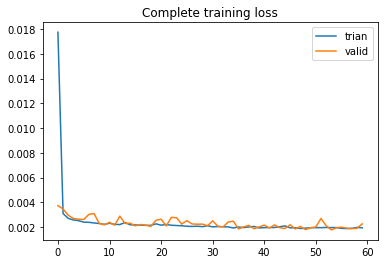

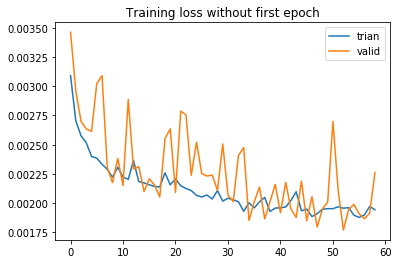

In [37]:
y1 = log.history['loss']
y2 = log.history['val_loss']
x = np.arange(0, len(y1), 1)
plt.figure()
l, = plt.plot(x, y1)
vl, = plt.plot(x, y2)
plt.title("Complete training loss")
plt.legend([l, vl], ["trian", "valid"])

y1 = log.history['loss'][1:]
y2 = log.history['val_loss'][1:]
x = np.arange(0, len(y1), 1)
plt.figure()
plt.title("Training loss without first epoch")
l, = plt.plot(x, y1)
vl, = plt.plot(x, y2)
plt.legend([l, vl], ["trian", "valid"])

### Save the model to file

In [113]:
# save weight
Indexer.save("indexer")

### Load model from saved file

In [7]:
# load model weight
Indexer = load_model("indexer")

In [118]:
Indexer.get_weights()

[array([[  1.15897406e-34,  -1.14942895e-06,   7.66148647e-35, ...,
           4.24189993e-35,   8.92693934e-05,  -3.97520965e-35],
        [  1.23115814e-35,  -8.62598708e-12,  -7.13965881e-35, ...,
          -9.70998741e-35,   8.39350250e-05,   6.81513972e-35],
        [  2.39981763e-35,  -1.71210431e-12,  -1.41790333e-35, ...,
           8.90862399e-35,  -2.72345387e-05,  -9.72225664e-36],
        [ -8.86724062e-35,  -9.68598295e-04,   9.94280417e-35, ...,
          -5.86160602e-35,   7.83460463e-10,  -1.09272761e-34]], dtype=float32),
 array([[ 0.02664782,  0.06651738,  0.0142363 , ...,  0.02303101,
          0.05140944, -0.00845538],
        [ 0.0333714 , -0.0179986 ,  0.02648518, ...,  0.00379638,
         -0.03366011,  0.01830651],
        [ 0.04238151,  0.02347548,  0.04490021, ...,  0.08290846,
         -0.03638997, -0.01559213],
        ..., 
        [-0.01464658, -0.11443044, -0.0130663 , ..., -0.0199059 ,
          0.03033726,  0.0128123 ],
        [ 0.02597379, -0.01590262

### An example of how to use the model to predict time series data

In [116]:
# example of prediction
input_seq = train_data['train_input'][0].reshape((-1, input_len, 4))
output = Indexer.predict(input_seq)
output

[array([[ 0.0814693]], dtype=float32),
 array([[ 0.04413065]], dtype=float32),
 array([[ 0.06606678]], dtype=float32)]

### Visualize result

In [9]:
def compare_output(predicted, correct, title, length=-1):
    if length < 0:
        x = np.arange(0, correct.shape[0] + length)
    else:
        x = np.arange(0, length)
    plt.figure(figsize=(22, 2))
    plt.title(title)
    sample_label, = plt.plot(x, correct[:length], label="sample")
    predict_label, = plt.plot(x, predicted[:length], label="predict")
    plt.legend([sample_label, predict_label], ["sample", "predict"])
    plt.plot()

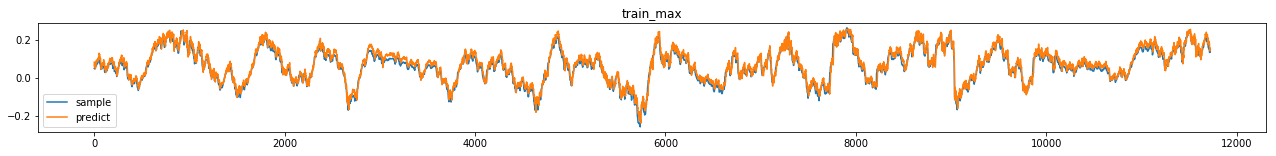

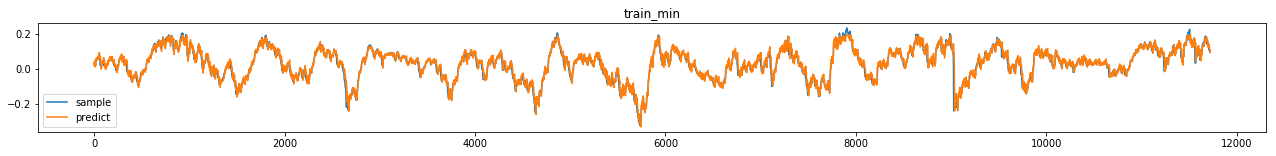

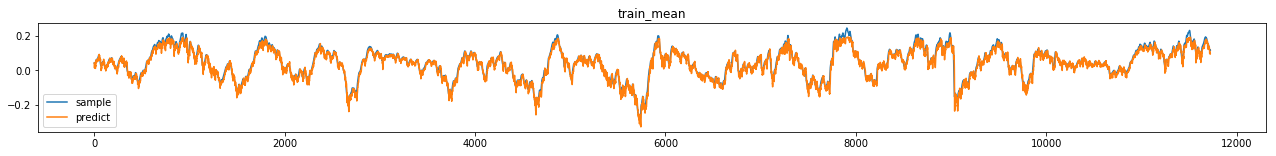

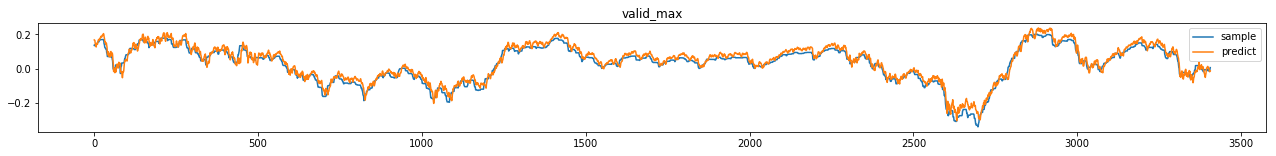

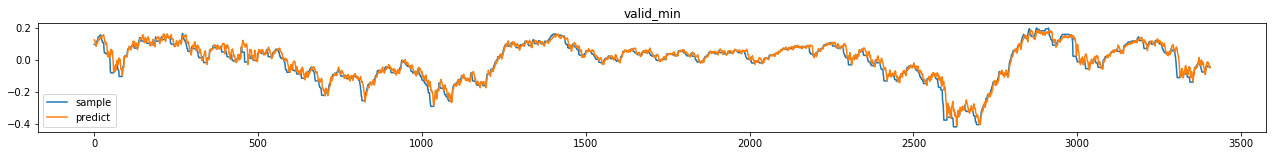

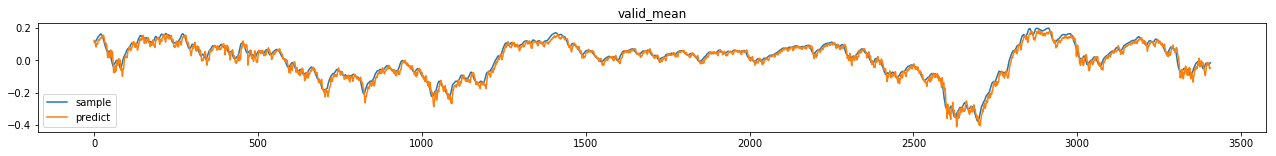

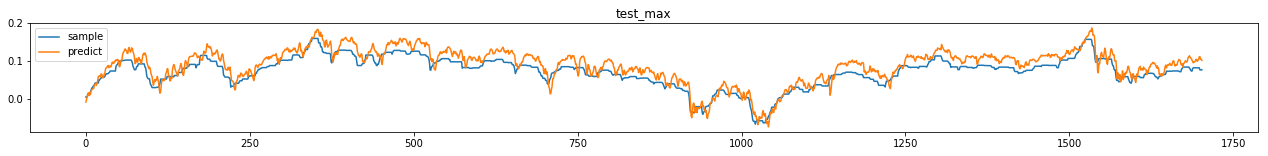

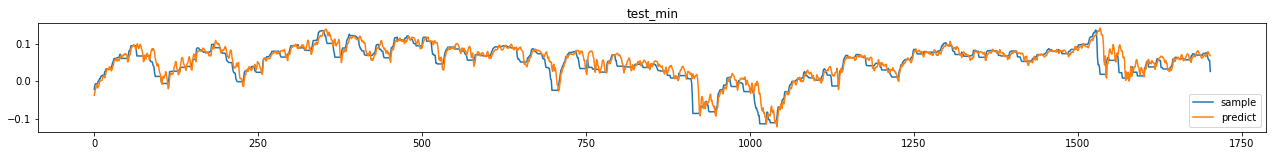

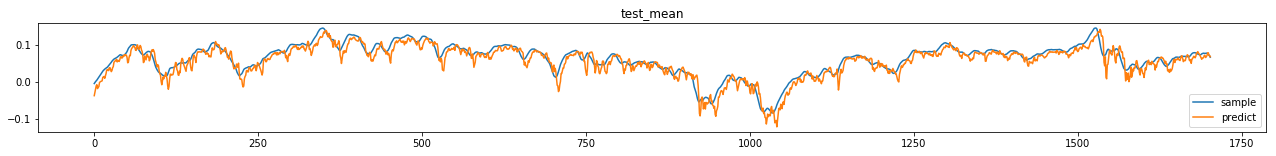

In [14]:
length = -1
which = "train"
predicted = Indexer.predict_on_batch([train_data[which+'_input']])
correct = train_data[which+'_output_max']
compare_output(predicted[0], correct, "train"+'_max', length)
correct = train_data[which+'_output_min']
compare_output(predicted[1], correct, "train"+"_min", length)
correct = train_data[which+'_output_mean']
compare_output(predicted[1], correct, "train"+"_mean", length)
which = "test"
predicted = Indexer.predict_on_batch([train_data[which+'_input']])
correct = train_data[which+'_output_max']
compare_output(predicted[0], correct, "valid"+'_max', length)
correct = train_data[which+'_output_min']
compare_output(predicted[1], correct, "valid"+"_min", length)
correct = train_data[which+'_output_mean']
compare_output(predicted[1], correct, "valid"+"_mean", length)
which = "valid"
predicted = Indexer.predict_on_batch([train_data[which+'_input']])
correct = train_data[which+'_output_max']
compare_output(predicted[0], correct, "test"+'_max', length)
correct = train_data[which+'_output_min']
compare_output(predicted[1], correct, "test"+"_min", length)
correct = train_data[which+'_output_mean']
compare_output(predicted[1], correct, "test"+"_mean", length)

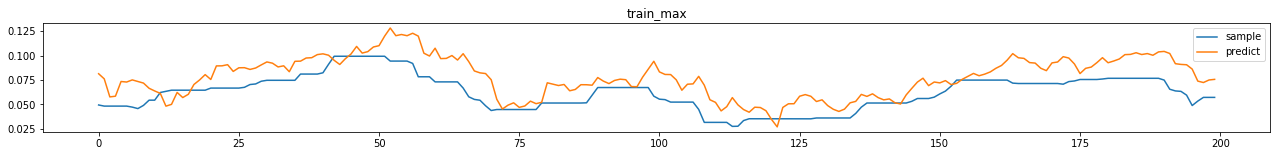

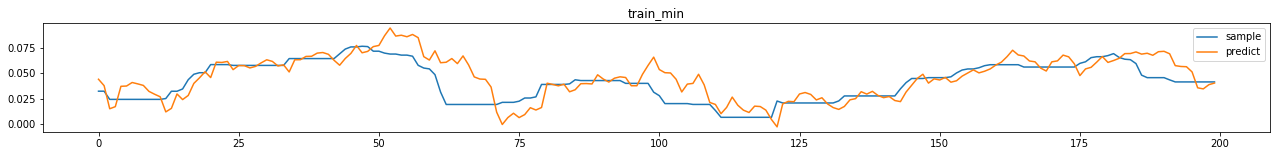

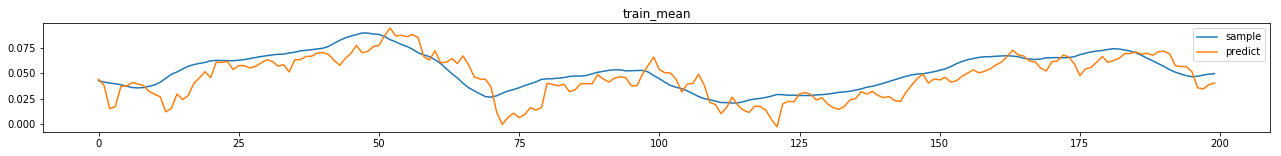

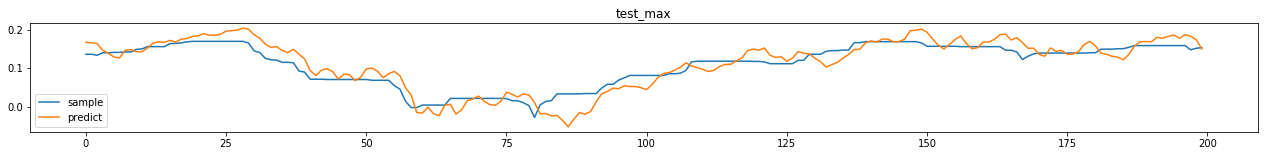

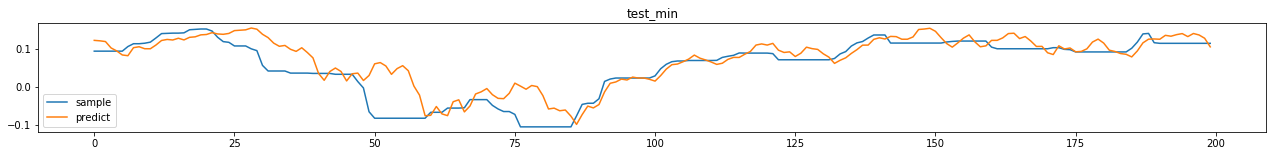

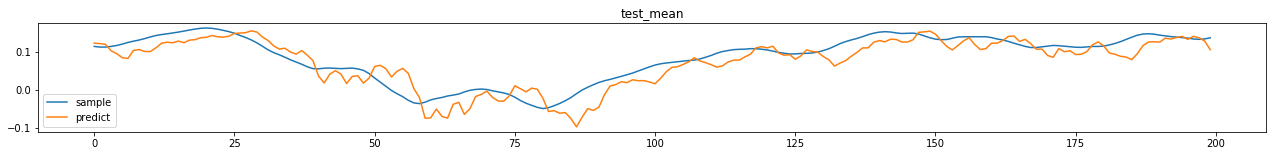

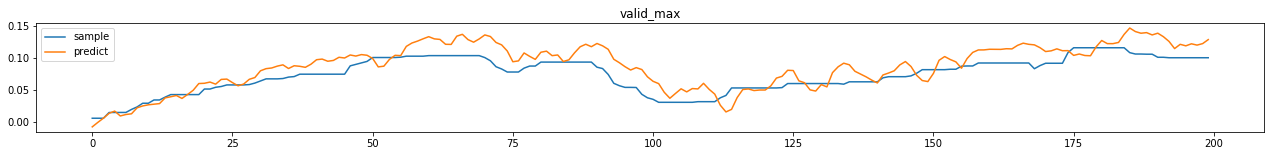

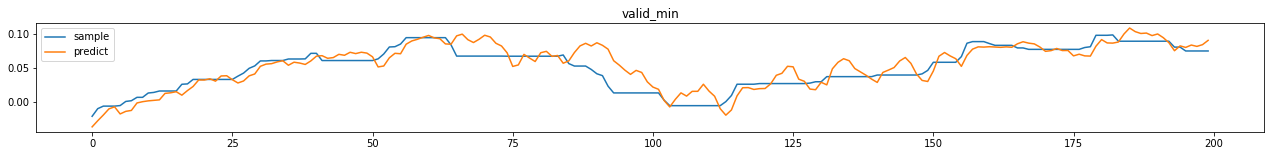

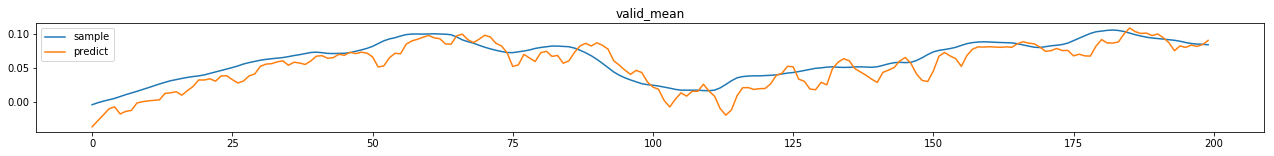

In [119]:
length = -1

for which in ["train", "test", "valid"]:
    predicted = Indexer.predict_on_batch([train_data[which+'_input']])
    correct = train_data[which+'_output_max']
    compare_output(predicted[0], correct, which+'_max', length)
    correct = train_data[which+'_output_min']
    compare_output(predicted[1], correct, which+"_min", length)
    correct = train_data[which+'_output_mean']
    compare_output(predicted[1], correct, which+"_mean", length)